# How to produce a popular movie? 
## Anlysis and prediction of movie market trend based on imdb datasets
### Table of Contents
* [Notebook Setup](#Notebook-Setup)
* [1. Business Objective](#1.-Business-Objective)
* [2. Get the Data](#2.-Get-the-Data)
* [3. Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)
* [4. Model Training](#4.-Model-Training)
* [5. Model Fine-tunning](#5.-Model-Fine-tunning)
* [6. Conclusion](#6.-Conclusion)
* [Reference](#Reference) 
* [Appendix](#Appendix)

### Notebook Setup

In [43]:
# common imports
import pandas as pd
import numpy as np
import shutil

# web scrapping imports
import requests as re
from bs4 import BeautifulSoup

# figure
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# ml model
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder

# random seed
np.random.seed(42)

In [215]:
# User defined functions
def get_name(nconst):
    response = re.get(f'https://www.imdb.com/name/{nconst}/')
    soup = BeautifulSoup(response.content)
    return soup.select('.header .itemprop')[0].text

def get_detail(nconst):
    arr = name_basics.primaryProfession[name_basics['nconst'].str.contains(nconst)].array
    return arr[0]

# data pre processing
def split_col_values_toList(dataFrame, seriesName, separator=',') -> list:
    temp_li = []
    for ele in dataFrame[str(seriesName)]:
        temp_li.append(str(ele).split(separator))
    return temp_li

def cat_col_idEncoder(dataFrame,seriesName) -> dict:
    """
    This function does the following steps:
    1. call split_col_values_toList to split the string category column
    2. call MultiLabelBinarizer to get unique category values
    3. return a category dictionary
    """
    cat_dic = {}
    countId = 0
    cat_list = split_col_values_toList(dataFrame,seriesName,separator=',')

    from sklearn.preprocessing import MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    mlb.fit_transform(cat_list)
    
    for val in mlb.classes_:
        if val not in cat_dic.keys():
            cat_dic[val] = countId
            countId +=1
            
    return cat_dic

def cat_col_idTransfer(dataFrame, seriesName) -> list:
    cat_list = split_col_values_toList(dataFrame,seriesName,separator=',')
    cat_dic = cat_col_idEncoder(dataFrame,seriesName)
    new_cat_list = []

    for elements in cat_list:
        elements = [key.replace(key, str(cat_dic[key])) for key in elements]
        new_cat_list.append(elements)
    
    return new_cat_list
    

def cat_col_seperator(dataFrame, seriesName):
    label1,label2,label3=[],[],[]
    
    for tags in dataFrame[seriesName]:
        label1.append(tags[0])
        label2.append(tags[1] if len(tags)==2 else np.NaN)
        label3.append(tags[2] if len(tags)==3 else np.NaN)
    
    dataFrame[str(seriesName)+'_1'],dataFrame[str(seriesName)+'_2'], dataFrame[str(seriesName)+'_3'] = label1,label2,label3
    dataFrame = dataFrame.drop(columns=seriesName)
    
    return dataFrame



#  1. Business Objective
https://www.imdb.com/interfaces/

Domain: movie


Filterings: 
   - Language: English
   - Region: tbd
   - Rating (filtered by number of votes >= median? mean? tbd)
   - Directoer
   - Stars

Probelm: trend analysis

Objective: popularity (heighest number of votes within heighest rating)




# 2. Get the Data

In [5]:
# convert tsv file to txt for pandas to read
with open('title.basics.tsv', 'rb') as f_in:
    with open('../title.basics.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

with open('title.akas.tsv', 'rb') as f_in:
    with open('../title.akas.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

with open('title.ratings.tsv', 'rb') as f_in:
    with open('../title.ratings.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
with open('title.crew.tsv', 'rb') as f_in:
    with open('../title.crew.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
with open('name.basics.tsv', 'rb') as f_in:
    with open('../name.basics.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

with open('title.principals.tsv', 'rb') as f_in:
    with open('../title.principals.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
# read txt file using pandas
title_basics = pd.read_csv('../title.basics.txt', sep='\t', low_memory=False)
title_akas = pd.read_csv('../title.akas.txt', sep = '\t', low_memory=False)
title_ratings = pd.read_csv('../title.ratings.txt', sep = '\t', low_memory=False)
title_crew = pd.read_csv('../title.crew.txt', sep = '\t', low_memory=False)
title_principals = pd.read_csv('../title.principals.txt', sep = '\t', low_memory=False)
name_basics = pd.read_csv('../name.basics.txt', sep = '\t', low_memory=False)

# show number of dataflows for each datasets


In [ ]:
# to delete
title_principals = pd.read_csv('../title.principals.txt', sep = '\t', low_memory=False)
title_crew = pd.read_csv('../title.crew.txt', sep = '\t', low_memory=False)
name_basics = pd.read_csv('../name.basics.txt', sep = '\t', low_memory=False)

In [ ]:
title_crew.tail(5)

cast = title_principals[title_principals['category'].isin(['actor', 'actress'])]
crew = title_principals[~title_principals['category'].isin(['actor', 'actress'])]

In [217]:
# Retrieve column names from original database
# this step is to avoid further multi-index problem
dblist = [title_akas,title_basics,title_ratings,title_crew]
idx = [col for db in dblist for col in db]

# Merge datasets using object unique id - 'tconst' and 'titleId'
df = pd.concat(dblist, axis=1, join='inner', keys=['titleId','tconst','tconst','tconst'], ignore_index=True)

# set column names
df.columns = idx 

# set'titleId' as index
# df = df.set_index('titleId') 

# set domian to movie object only
df = df.drop(df[df.titleType != 'movie'].index) 

# delete uncessary columns 
col_2_drop = ['title','ordering','tconst','endYear','titleType','types','attributes','isOriginalTitle','originalTitle']
df = df.drop(col_2_drop, axis=1)

# delete na values
for col in df.columns.values:
    df = df[df[col] != '\\N']
    
# Finally present the merged dataframe for review
print(df.shape)
df.head(5)

(18235, 12)


,titleId,region,language,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers
3330,tt0000969,XWW,en,The Sea Wolf,0,1913,70,Drama,6.9,2910,nm0098376,"nm0098376,nm0518711"
3436,tt0001004,XWW,en,Traffic in Souls,0,1913,88,"Crime,Drama",6.1,283,nm0875869,"nm0534073,nm0875869"
3961,tt0001212,ES,ca,Gatans barn,0,1914,54,Drama,8.3,26,nm0803705,"nm0461721,nm0461743"
3971,tt0001215,XWW,en,The Ghost Breaker,0,1914,60,"Adventure,Horror",6.9,28,"nm0001124,nm0002177","nm0002177,nm0001124,nm0225469,nm0323766,nm0599800"
4971,tt0001593,JP,ja,Buckshot John,0,1915,50,Western,6.0,20,nm0098376,"nm0340584,nm0887428"


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18235 entries, 3330 to 1215932
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   titleId         18235 non-null  object 
 1   region          18235 non-null  object 
 2   language        18235 non-null  object 
 3   primaryTitle    18235 non-null  object 
 4   isAdult         18235 non-null  object 
 5   startYear       18235 non-null  object 
 6   runtimeMinutes  18235 non-null  object 
 7   genres          18235 non-null  object 
 8   averageRating   18235 non-null  float64
 9   numVotes        18235 non-null  int64  
 10  directors       18235 non-null  object 
 11  writers         18235 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.8+ MB


In [219]:
# convert column dtypes
num_col = ['runtimeMinutes','isAdult']
for col in num_col:
    df[col] = df[col].astype(int)

cat_col = ['region','language']
for col in cat_col:
    df[col] = df[col].astype('category')
    
df.startYear = pd.to_datetime(df.startYear, format="%Y").dt.year

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18235 entries, 3330 to 1215932
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   titleId         18235 non-null  object  
 1   region          18235 non-null  category
 2   language        18235 non-null  category
 3   primaryTitle    18235 non-null  object  
 4   isAdult         18235 non-null  int64   
 5   startYear       18235 non-null  int64   
 6   runtimeMinutes  18235 non-null  int64   
 7   genres          18235 non-null  object  
 8   averageRating   18235 non-null  float64 
 9   numVotes        18235 non-null  int64   
 10  directors       18235 non-null  object  
 11  writers         18235 non-null  object  
dtypes: category(2), float64(1), int64(4), object(5)
memory usage: 1.6+ MB


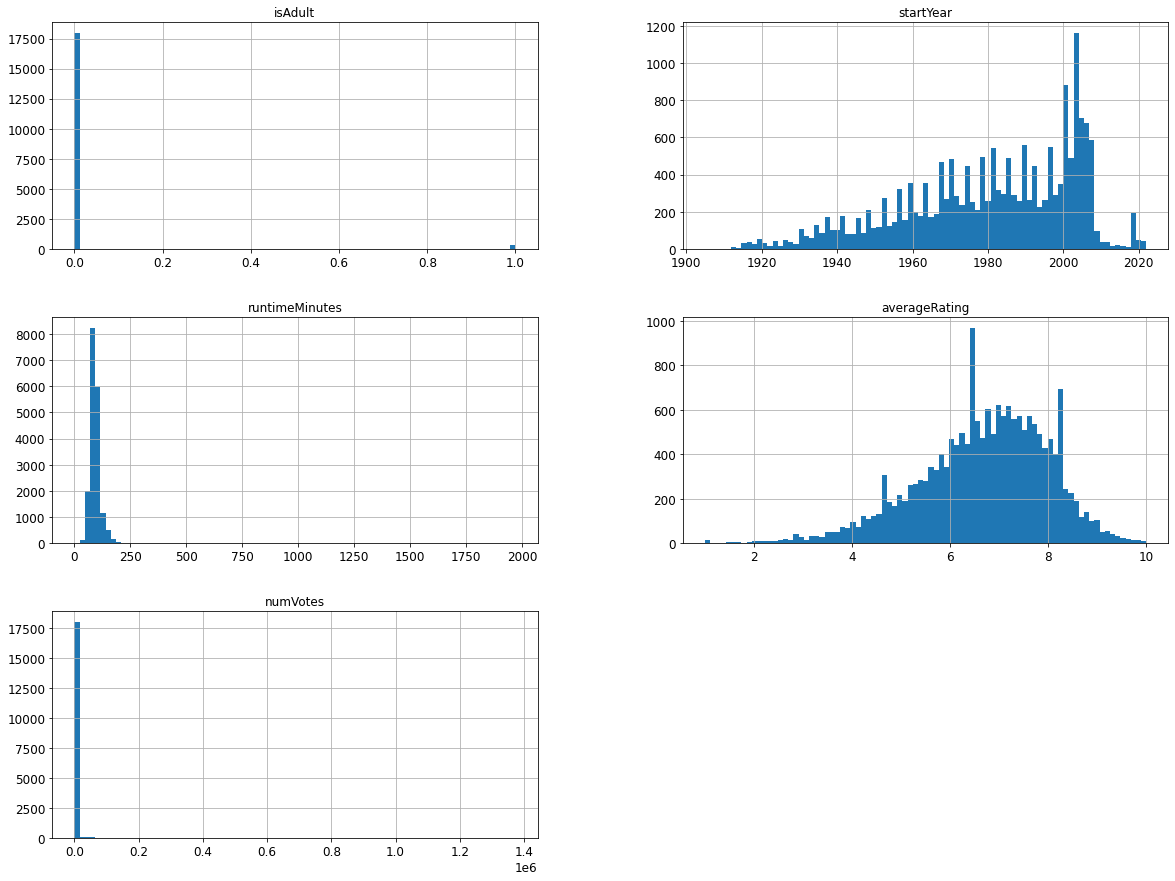

In [20]:
df.hist(bins=85, figsize=(20,15))
plt.show()

# 3. Exploratory Data Analysis

### Discover and visualize the data to gain insights


1. five most commonlly used language



* primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
* originalTitle (string) - original title, in the original language
* isAdult (boolean) - 0: non-adult title; 1: adult title

In [222]:
cat_dic = cat_col_idEncoder(df, 'genres')
df['genresId'] = cat_col_idTransfer(df, 'genres')
cat_col_seperator(df, 'genresId')


,titleId,region,language,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers,genresId,genresId_1,genresId_2,genresId_3
3330,tt0000969,XWW,en,The Sea Wolf,0,1913,70,Drama,6.9,2910,nm0098376,"nm0098376,nm0518711",[8],8,NaN,NaN
3436,tt0001004,XWW,en,Traffic in Souls,0,1913,88,"Crime,Drama",6.1,283,nm0875869,"nm0534073,nm0875869","[6, 8]",6,8,NaN
3961,tt0001212,ES,ca,Gatans barn,0,1914,54,Drama,8.3,26,nm0803705,"nm0461721,nm0461743",[8],8,NaN,NaN
3971,tt0001215,XWW,en,The Ghost Breaker,0,1914,60,"Adventure,Horror",6.9,28,"nm0001124,nm0002177","nm0002177,nm0001124,nm0225469,nm0323766,nm0599800","[2, 13]",2,13,NaN
4971,tt0001593,JP,ja,Buckshot John,0,1915,50,Western,6.0,20,nm0098376,"nm0340584,nm0887428",[24],24,NaN,NaN


In [321]:
dcat_count_dic = dict.fromkeys(list(cat_dic.keys()))
dcat_count_dic

for k,v in cat_dic.items():
    count = 0
    for li in cat_col_idTransfer(df, 'genres'):
        for nu in li:
            if int(nu) == int(v):
                count += 1
    cat_count_dic[k] = count

In [343]:
cat_count_dic = {k: v for k, v in sorted(cat_count_dic.items(), key=lambda item: item[1], reverse=True)}
keys = cat_count_dic.keys()
values = cat_count_dic.values()

plt.bar(keys, values)

for k,v in cat_count_dic.items():
    plt.text(v, k, str(k))

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fb989b851f0> (for post_execute):


ConversionError: Failed to convert value(s) to axis units: 'Drama'

ConversionError: Failed to convert value(s) to axis units: 'Drama'

<Figure size 432x288 with 1 Axes>

language
en     4675
ja     4256
ru     2451
fr     1897
tr     1002
qbn     827
bg      732
sr      732
sv      346
ca      159
Name: titleId, dtype: int64


<AxesSubplot:ylabel='language'>

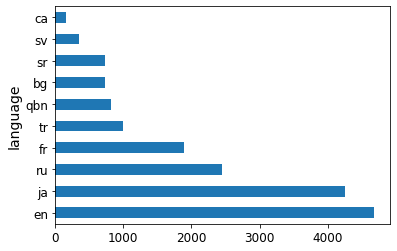

In [338]:
lang_top_10 = df.groupby(['language'])['titleId'].count().sort_values(ascending=False)[:10]
print(lang_top_10)
lang_top_10.plot(kind="barh")

In [92]:
genres = df.groupby(df['genres'])['titleId'].count().sort_values(ascending=False)
genres.plot(kind='barh')

TypeError: unhashable type: 'list'

In [147]:
df.genres

3330                        Drama
3436                  Crime,Drama
3961                        Drama
3971             Adventure,Horror
4971                      Western
                    ...          
1212368                     Drama
1212560                     Drama
1214505                    Horror
1215227    Action,Animation,Crime
1215932               Documentary
Name: genres, Length: 18235, dtype: object

In [166]:




# res = pd.DataFrame(mlb.fit_transform(x),columns=mlb.classes_)
# res.columns

array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Reality-TV',
       'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War',
       'Western'], dtype=object)

# 4. Model Training


# 5. Model Fine-tunning

# 6. Conclusion

# Appendix

# Reference